In [1]:
import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
import gensim.downloader as api
import matplotlib.pyplot as plt
import sklearn.metrics as measure

In [2]:
aud_type = 'pa'
vid_type = 'pv' 
# decoded_aud_trn = torch.load('embeddings/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_trn.pt')
# decoded_aud_val = torch.load('embeddings/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_val.pt')
# decoded_vid_trn = torch.load('embeddings/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_trn.pt')
# decoded_vid_val = torch.load('embeddings/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_val.pt')

# decoded_aud_trn = torch.load('embeddings/zero_shot/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_trn.pt')
# decoded_aud_val = torch.load('embeddings/zero_shot/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_val.pt')
# decoded_vid_trn = torch.load('embeddings/zero_shot/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_trn.pt')
# decoded_vid_val = torch.load('embeddings/zero_shot/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_val.pt')

decoded_aud_trn = torch.load('embeddings_ctl/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_trn.pt')
decoded_aud_val = torch.load('embeddings_ctl/'+aud_type+'_'+vid_type+'/decoded_'+aud_type+'_aud_val.pt')
decoded_vid_trn = torch.load('embeddings_ctl/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_trn.pt')
decoded_vid_val = torch.load('embeddings_ctl/'+aud_type+'_'+vid_type+'/decoded_'+vid_type+'_vid_val.pt')

# decoded_vid_trn = torch.load('../explore_audio/decoded_vid_trn.pt')
# decoded_vid_val = torch.load('../explore_audio/decoded_vid_val.pt')

In [3]:
agg_trn = torch.stack((decoded_vid_trn, decoded_aud_trn)).mean(dim=0)
agg_val = torch.stack((decoded_vid_val, decoded_aud_val)).mean(dim=0)

In [4]:
def get_labels():
    TRAIN_DATA_PATH_1 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_0-150_embeddings.pt"
    TRAIN_DATA_PATH_2 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_150-300_embeddings.pt"
    TRAIN_DATA_PATH_3 = "../../data/embeddings/wav2vec/pretrained_out/audio_trn_300-440_embeddings.pt"
    VAL_DATA_PATH = "../../data/embeddings/wav2vec/pretrained_out/audio_val_0-108_embeddings.pt"

    data_train_1 = torch.load(TRAIN_DATA_PATH_1)
    data_train_2 = torch.load(TRAIN_DATA_PATH_2)
    data_train_3 = torch.load(TRAIN_DATA_PATH_3)
    data_val = torch.load(VAL_DATA_PATH)

    y_trn = np.hstack((data_train_1["y"], data_train_2["y"], data_train_3["y"]))

    return y_trn, data_val["y"]


In [5]:
y_trn, y_val = get_labels()

In [6]:
# y_trn = np.delete(y_trn, np.where(y_trn == 'Dance')[0], axis=0)

In [7]:
wv = api.load('word2vec-google-news-300')

In [8]:
text_embed_mapping = {
    'Couple Romance':wv['romance'],
    'Dance':wv['dance'],
    'Heartbreak Romance':wv['heartbreak'],
    'Memes':wv['memes'],
    'Pranks':wv['prank'],
}

In [9]:
x_text_trn = torch.tensor(np.array([text_embed_mapping[v] for v in y_trn]))
x_text_val = torch.tensor(np.array([text_embed_mapping[v] for v in y_val]))
#move x_text to cuda
x_text_trn = x_text_trn.cuda()
x_text_val = x_text_val.cuda()

In [10]:
def knn(modal_tensor, label_feats, neighbours, train_or_val):
    if train_or_val == 'trn':
        y = y_trn
    elif train_or_val == 'val':
        y = y_val
    pdist = torch.nn.PairwiseDistance(p=2)
    preds = []
    for modal_inst in modal_tensor:
        dists = []
        for label_feat in torch.tensor(label_feats):
            output = pdist(modal_inst, label_feat)
            dists.append(output)
        neigh_preds = []
        for i in range(neighbours):
            min_index = dists.index(min(dists)) + i
            pred = y[min_index]
            neigh_preds.append(pred)
            dists.pop(min_index)
        #find the most frequent element in neigh_preds
        pred = max(set(neigh_preds), key = neigh_preds.count)
        preds.append(pred)
    return preds


In [1]:
# def knn_mean_dist(audio_tensor, video_tensor, label_feats, neighbours, train_or_val):
#     if train_or_val == 'trn':
#         y = y_trn
#     elif train_or_val == 'val':
#         y = y_val
#     pdist = torch.nn.PairwiseDistance(p=2)
#     preds = []
#     for audio_inst, video_inst in zip(audio_tensor, video_tensor):
#         dists_audio = []
#         dists_video = []

#         for label_feat in torch.tensor(label_feats):
#             output_audio = pdist(audio_inst, label_feat)
#             dists_audio.append(output_audio)

#             output_video = pdist(video_inst, label_feat)
#             dists_video.append(output_video)

#         dists = [sum(x)/2 for x in zip(dists_audio, dists_video)]
            
#         neigh_preds = []
#         for i in range(neighbours):
#             min_index = dists.index(min(dists)) + i
#             pred = y[min_index]
#             neigh_preds.append(pred)
#             dists.pop(min_index)
#         #find the most frequent element in neigh_preds
#         pred = max(set(neigh_preds), key = neigh_preds.count)
#         preds.append(pred)
#     return preds


In [12]:
def get_acc_cm(y, preds):
    accuracy = measure.accuracy_score(y, preds)
    print(f"{accuracy:.3f}")
    disp = measure.ConfusionMatrixDisplay.from_predictions(
                y,
                preds,
                normalize="true",
                xticks_rotation=45
                )

    plt.show()

In [13]:
preds_vid_val = knn(decoded_vid_val, x_text_val, 1, 'val')
preds_aud_val = knn(decoded_aud_val, x_text_val, 1, 'val')
preds_agg_val = knn(agg_val, x_text_val, 1, 'val')


/tmp/ipykernel_7788/2746645832.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for label_feat in torch.tensor(label_feats):


In [14]:
preds_mean_val = knn_mean_dist(decoded_aud_val, decoded_vid_val, x_text_val, 1, 'val')

/tmp/ipykernel_7788/1391958863.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for label_feat in torch.tensor(label_feats):


0.463


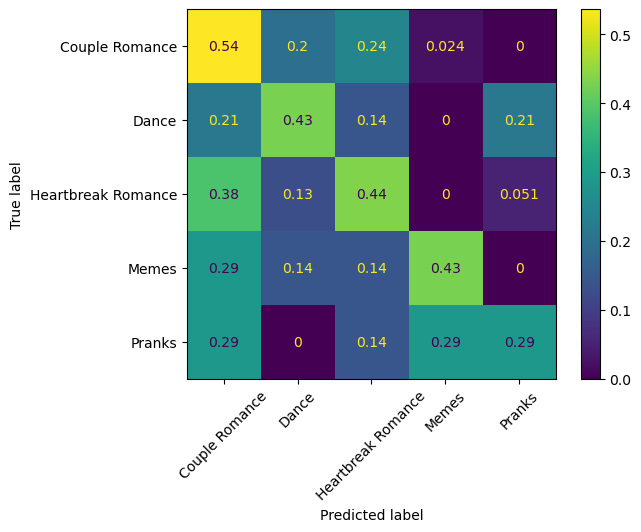

In [15]:
get_acc_cm(y_val, preds_aud_val)

0.602


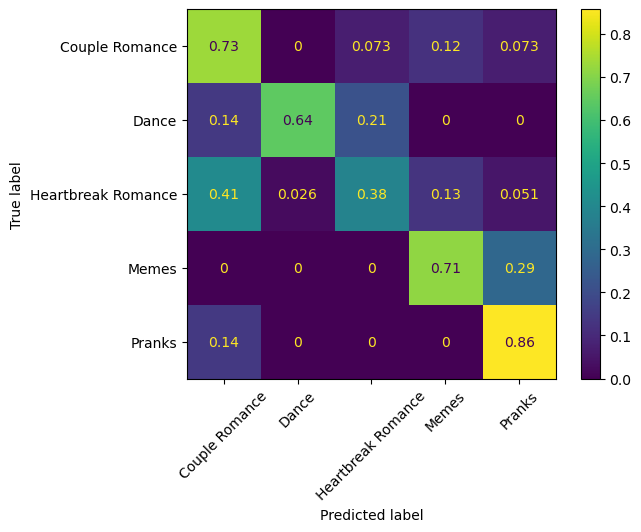

In [16]:
get_acc_cm(y_val, preds_vid_val)

0.602


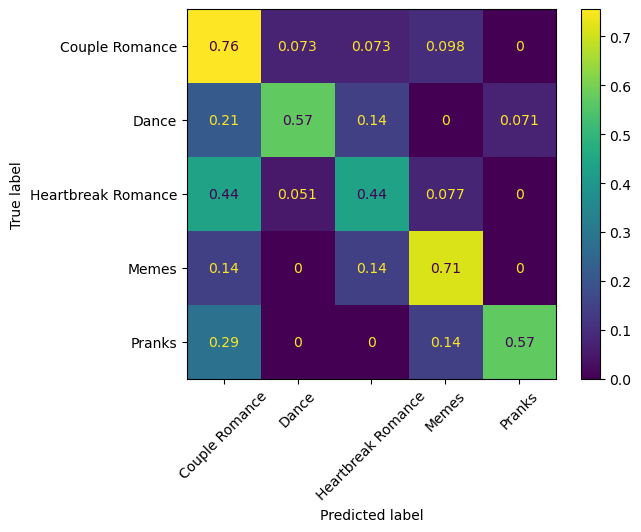

In [17]:
get_acc_cm(y_val, preds_agg_val)

In [2]:
# get_acc_cm(y_val, preds_mean_val)